In [51]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.data.experimental import cardinality as tf_caridnality
#callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL


from tensorflow.config import list_physical_devices

#check the GPU use
print("Num GPUs Available: ", len(list_physical_devices('GPU')))


Num GPUs Available:  1


In [52]:
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 32
IMAGE_SIZE = (64, 376)
SHUFLE_VALUE = True
RANDOM_SEED = 42
TEST_SIZE_PART = 1

data_dir = "../raw_data/images_png/"

train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=RANDOM_SEED,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  color_mode = "grayscale",
  shuffle = SHUFLE_VALUE)

val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  seed=RANDOM_SEED,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  color_mode = "grayscale",
  shuffle = SHUFLE_VALUE)


Found 38044 files belonging to 34 classes.
Using 26631 files for training.
Found 38044 files belonging to 34 classes.
Using 11413 files for validation.


In [53]:
val_batches = tf_caridnality(val_ds)
test_ds = val_ds.take((TEST_SIZE_PART*val_batches) // 3)
val_ds = val_ds.skip((TEST_SIZE_PART*val_batches) // 3)


In [54]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)


['banswa', 'barswa', 'calqua', 'cangoo', 'caster1', 'comloo', 'comrav', 'comred', 'comter', 'eargre', 'eucdov', 'eursta', 'gadwal', 'gnwtea', 'goleag', 'greegr', 'hergul', 'horlar', 'houspa', 'mallar3', 'merlin', 'norsho', 'osprey', 'pecsan', 'perfal', 'redcro', 'ribgul', 'rinduc', 'rocpig', 'rudduc', 'sheowl', 'silence', 'snobun', 'tunswa']


In [55]:
import PIL
import PIL.Image
image_path = os.path.join(data_dir ,'banswa', 'XC140286_87.png')
np.array(PIL.Image.open(image_path)).shape


(64, 376)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 376, 1)


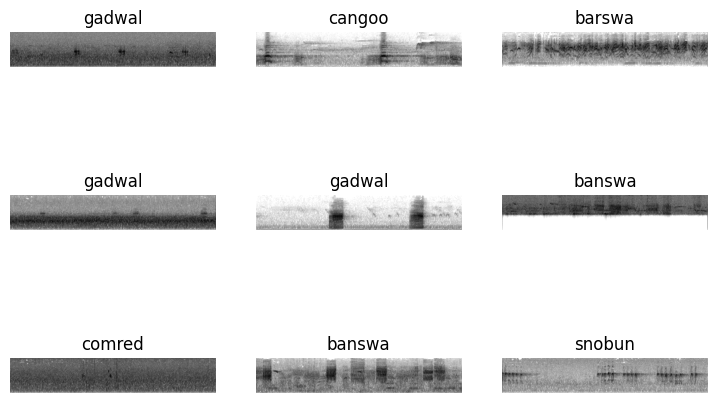

In [56]:

plt.figure(figsize=(9, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    #img = tf.io.read_file(path)
    print(type(images[i]))

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    print(images[i].numpy().astype("uint16").shape)
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [62]:
model_1 = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(64, 376, 1)),
  keras.layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(1568, activation='relu'),
  keras.layers.Dense(500, activation='relu'),
  keras.layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [63]:
model_1.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 64, 376, 1)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 376, 64)       320       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 32, 188, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 188, 64)       24640     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 16, 94, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 16, 94, 64)       

In [64]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

# We will store the logs in a folder (one folder per fit)
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [65]:
from birdsong.utils import create_folder_if_not_exists

# Create a callback that saves the model's weights
checkpoint_folder_path = "../models_checkpoints/raman_model_test_baseline/"
create_folder_if_not_exists(checkpoint_folder_path)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(checkpoint_folder_path,"cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

PATIENCE = 6

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=PATIENCE)



# Calculate the number of batches per epoch
import math
n_batches = len(train_ds) / BATCH_SIZE
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')


In [66]:

epochs=30

# Save the weights using the `checkpoint_path` format
model_1.save_weights(checkpoint_path.format(epoch=0))

history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es,tensorboard_callback,cp_callback])


Epoch 1/30


2023-12-02 21:19:37.564575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


831/833 [============================>.] - ETA: 0s - loss: 2.9758 - accuracy: 0.1861
Epoch 1: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0001.ckpt
833/833 [==============================] - 32s 35ms/step - loss: 2.9752 - accuracy: 0.1863 - val_loss: 2.6349 - val_accuracy: 0.2810
Epoch 2/30
831/833 [============================>.] - ETA: 0s - loss: 2.3558 - accuracy: 0.3378
Epoch 2: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0002.ckpt
833/833 [==============================] - 29s 35ms/step - loss: 2.3554 - accuracy: 0.3380 - val_loss: 2.1520 - val_accuracy: 0.3983
Epoch 3/30
832/833 [============================>.] - ETA: 0s - loss: 1.9599 - accuracy: 0.4460
Epoch 3: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0003.ckpt
833/833 [==============================] - 29s 35ms/step - loss: 1.9598 - accuracy: 0.4460 - val_loss: 1.8638 - val_accuracy: 0.4722
Epoch 4/30
831/833 [============================>.] - ETA: 0s - lo

In [68]:
%tensorboard --logdir logs/fit

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


Reusing TensorBoard on port 6006 (pid 99382), started 0:00:28 ago. (Use '!kill 99382' to kill it.)

In [69]:
def plot_history(history, metric_label, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name

    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(min(history.history['loss']) * 0.8,
                 max(history.history['loss']) * 1.1,)
    ax1.set_title('loss')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)

    ax2.plot(history.history[metric_label], label='train ' + metric_label  + exp_name)
    ax2.plot(history.history['val_'+metric_label], label='val ' + metric_label  + exp_name)
    ax2.set_ylim(min(history.history[metric_label]) * 0.8,
                 max(history.history[metric_label]) * 1.1)
    ax2.set_title(metric_label.capitalize())
    ax2.legend()
    ax2.set_xlabel('epochs')
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    return (ax1, ax2)


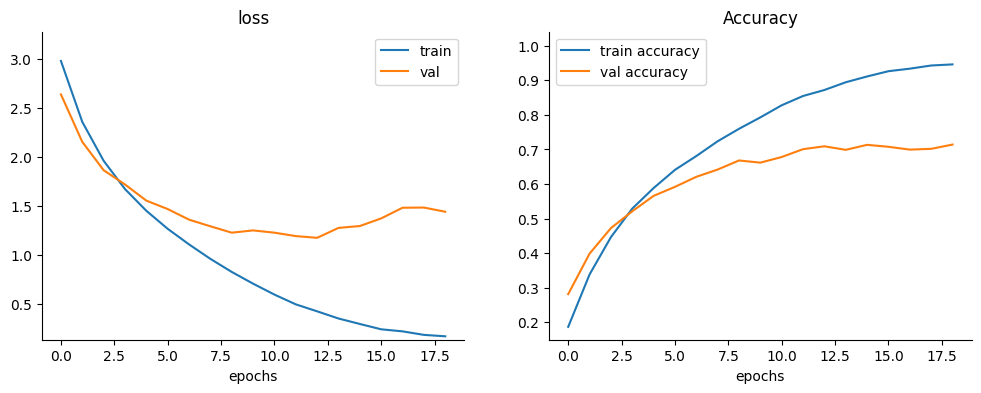

In [70]:
plot_history(history, 'accuracy', title='', axs=None, exp_name="")
plt.show()


In [71]:
predictions = model_1.predict(test_ds)


119/119 [==============================] - 1s 5ms/step


In [72]:
(n_rows, n_columns) = predictions.shape
score_pred = []
for n in range(n_rows):
    score_pred.append([np.argmax(predictions[n]),
                       class_names[np.argmax(predictions[n])],"this song most likely belongs to {} with a {:.2f} percent confidence."\
                       .format(class_names[np.argmax(predictions[n])], 100 * np.max(predictions[n]))])

df = pd.DataFrame(score_pred, columns=["prediction", "class", "description"])


In [73]:
df


,prediction,class,description
0,22,osprey,this song most likely belongs to osprey with a...
1,20,merlin,this song most likely belongs to merlin with a...
2,6,comrav,this song most likely belongs to comrav with a...
3,32,snobun,this song most likely belongs to snobun with a...
4,0,banswa,this song most likely belongs to banswa with a...
...,...,...,...
3803,4,caster1,this song most likely belongs to caster1 with ...
3804,30,sheowl,this song most likely belongs to sheowl with a...
3805,3,cangoo,this song most likely belongs to cangoo with a...
3806,3,cangoo,this song most likely belongs to cangoo with a...


In [74]:
(loss_evaluate,accuracy_evaluate) =  model_1.evaluate(test_ds)


  8/119 [=>............................] - ETA: 0s - loss: 1.8790 - accuracy: 0.7031

119/119 [==============================] - 1s 7ms/step - loss: 1.4485 - accuracy: 0.7172


In [78]:
reg_l2 = keras.regularizers.L2(0.01)

model_2 = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(64, 376, 1)),
  keras.layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.26),
  keras.layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.04),
  keras.layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, (4,4), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(1568, activation='relu',activity_regularizer=reg_l2),
  keras.layers.Dense(500, activation='relu',activity_regularizer=reg_l2),
  keras.layers.Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [79]:
from birdsong.utils import create_folder_if_not_exists

# Create a callback that saves the model's weights
checkpoint_folder_path = "../models_checkpoints/raman_model_test_baseline_2/"
create_folder_if_not_exists(checkpoint_folder_path)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(checkpoint_folder_path,"cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

PATIENCE = 6

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=PATIENCE)



# Calculate the number of batches per epoch
import math
n_batches = len(train_ds) / BATCH_SIZE
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')


In [80]:

epochs=30

# Save the weights using the `checkpoint_path` format
model_2.save_weights(checkpoint_path.format(epoch=0))

history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es,tensorboard_callback,cp_callback])


Epoch 1/30
833/833 [==============================] - ETA: 0s - loss: 3.0783 - accuracy: 0.2069
Epoch 1: saving model to ../models_checkpoints/raman_model_test_baseline_2/cp-0001.ckpt
833/833 [==============================] - 33s 36ms/step - loss: 3.0783 - accuracy: 0.2069 - val_loss: 2.7405 - val_accuracy: 0.3232
Epoch 2/30
833/833 [==============================] - ETA: 0s - loss: 2.4832 - accuracy: 0.3711
Epoch 2: saving model to ../models_checkpoints/raman_model_test_baseline_2/cp-0002.ckpt
833/833 [==============================] - 30s 36ms/step - loss: 2.4832 - accuracy: 0.3711 - val_loss: 2.3663 - val_accuracy: 0.3984
Epoch 3/30
833/833 [==============================] - ETA: 0s - loss: 2.1376 - accuracy: 0.4705
Epoch 3: saving model to ../models_checkpoints/raman_model_test_baseline_2/cp-0003.ckpt
833/833 [==============================] - 30s 36ms/step - loss: 2.1376 - accuracy: 0.4705 - val_loss: 2.0614 - val_accuracy: 0.4857
Epoch 4/30
832/833 [============================>

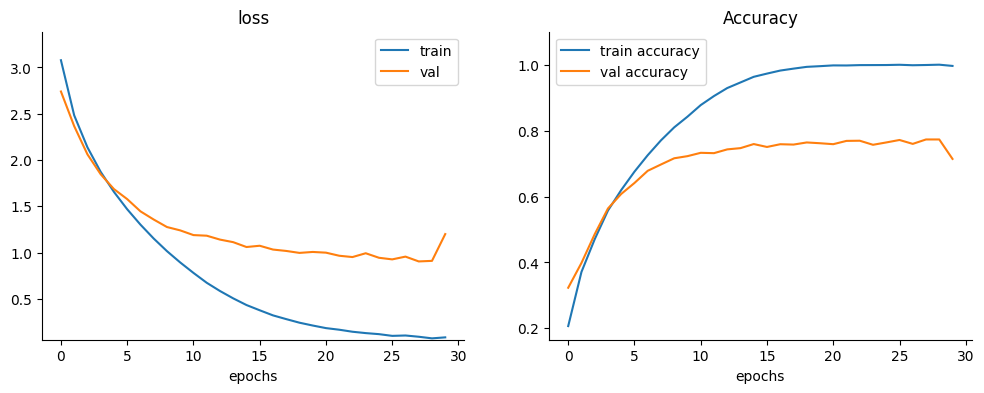

In [81]:
plot_history(history, 'accuracy', title='', axs=None, exp_name="")
plt.show()
